In [1]:
devtools::install_github("clairbarnes/rwwa")
library(rwwa)

Skipping install of 'rwwa' from a github remote, the SHA1 (a428e9e0) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot


Loading required package: plyr


Attaching package: ‘plyr’


The following object is masked from ‘package:distillery’:

    is.formula




# Fit linear trend to all obs

In [3]:
datasets = c("chirps", "cpc", "mswep", "tamsat")
region = "obs"
varnm = "rx30day"

In [4]:
gmst = read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]
nino = load_ts("ts/EA-floods_nino-djf_obs_ersst.dat", col.names = c("year", "nino"))
iod = load_ts("ts/EA-floods_iod-mam_obs_ersst.dat", col.names = c("year", "iod"))

df <- merge(merge(gmst, nino), iod)

# define factual & counterfactual covariates
cov_2024 <- df[df$year == 2024,c("gmst", "nino", "iod"), drop = F]

cov_cf <- rbind("pi" = cov_2024 - c(1.2,0,0),
                "nino_neut" = c("gmst" = cov_2024$gmst, "nino" = 0, "iod" = cov_2024$iod),
                "iod_neut" = c("gmst" = cov_2024$gmst, "nino" = cov_2024$nino, "iod" = 0))

In [11]:
# Bootstrap model fit - GMST only
nsamp <- 1000
for (ds in datasets) {
    
    fnm <- paste0("ts/EA-floods_",varnm,"_",region,"_",ds,".dat")
    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res-gmst_", fnm))
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("gev", "fixeddisp", df, "pr", c("gmst"), lower = F)
        res <- boot_ci(mdl, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop = F], nsamp = nsamp)                                 
        write.csv(rbind(res, "nino_corr" = rep(0, 3)), res_fnm)
    }
}

ERROR: Error in parse(text = x, srcfile = src): <text>:14:5: unexpected '}'
13:         write.csv(rbind(res, "nino_corr" = rep(0, 3), res_fnm)
14:     }
        ^


In [6]:
# Bootstrap model fit - GMST + Nino
nsamp <- 1000
for (ds in datasets) {
    
    fnm <- paste0("ts/EA-floods_",varnm,"_",region,"_",ds,".dat")
    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res-gmst-nino_", fnm))
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("gev", "fixeddisp", df, "pr", c("gmst", "nino"), lower = F)
        res <- boot_ci(mdl, cov_f = cov_2024, cov_cf = cov_cf, nsamp = nsamp)
        
        # get correlation between Nino3.4 and rainy season precip, for evaluation
        set.seed(42)
        nino_corr <- c(cor(df$nino, df$pr), quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(mdl$data), replace = T), c("nino", "pr")])[1,2]), c(0.025, 0.975)))
                                                   
        write.csv(rbind(res, nino_corr), res_fnm)
    }
}

In [101]:
# Bootstrap model fit - GMST + IOD
nsamp <- 1000
for (ds in datasets) {
    
    fnm <- paste0("ts/EA-floods_",varnm,"_",region,"_",ds,".dat")
    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res-gmst-iod_", fnm))
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(merge(gmst, nino), iod), ts)

        mdl <- fit_ns("gev", "fixeddisp", df, "pr", c("gmst", "iod"), lower = F)
        res <- boot_ci(mdl, cov_f = cov_2024, cov_cf = cov_cf, nsamp = nsamp)
        
        # get correlation between Nino3.4 and rainy season precip, for evaluation
        set.seed(42)
        nino_corr <- c(cor(df$nino, df$pr), quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(mdl$data), replace = T), c("nino", "pr")])[1,2]), c(0.025, 0.975)))
                                                   
        write.csv(rbind(res, nino_corr), res_fnm)
    }
}

## Compare AIC & RMSE

In [136]:
rmse <- function(mdl) mean((mdl$x - ns_pars(mdl)$loc)^2)^{1/2}

In [148]:
models_gmst <- sapply(datasets, function(ds) {
    df_ds <- merge(df, load_ts(paste0("ts/EA-floods_",varnm,"_",region,"_",ds,".dat"), col.names = c("year", "pr")))
    mdl <- fit_ns("gev", "fixeddisp", df_ds, "pr", c("gmst"), lower = F) 
}, simplify = F)

models_nino <- sapply(datasets, function(ds) {
    df_ds <- merge(df, load_ts(paste0("ts/EA-floods_",varnm,"_",region,"_",ds,".dat"), col.names = c("year", "pr")))
    mdl <- fit_ns("gev", "fixeddisp", df_ds, "pr", c("gmst", "nino"), lower = F)
}, simplify = F)

models_iod <- sapply(datasets, function(ds) {
    df_ds <- merge(df, load_ts(paste0("ts/EA-floods_",varnm,"_",region,"_",ds,".dat"), col.names = c("year", "pr")))
    mdl <- fit_ns("gev", "fixeddisp", df_ds, "pr", c("gmst", "iod"), lower = F)
}, simplify = F)

models_nino_iod <- sapply(datasets, function(ds) {
    df_ds <- merge(df, load_ts(paste0("ts/EA-floods_",varnm,"_",region,"_",ds,".dat"), col.names = c("year", "pr")))
    mdl <- fit_ns("gev", "fixeddisp", df_ds, "pr", c("gmst", "nino", "iod"), lower = F)
}, simplify = F)

In [133]:
rbind("gmst" = sapply(models_gmst, aic), "gmst + nino" = sapply(models_nino, aic), "gmst + iod" = sapply(models_iod, aic), "gmst + nino + iod" = sapply(models_nino_iod, aic))

,chirps,cpc,mswep,tamsat
gmst,446.7220,458.2732,473.8616,420.8199
gmst + nino,442.6278,455.3125,473.5884,420.2332
gmst + iod,448.0142,460.1691,475.8385,418.6886
gmst + nino + iod,443.9780,457.2834,475.5214,418.1099


In [137]:
rbind("gmst" = sapply(models_gmst, rmse), "gmst + nino" = sapply(models_nino, rmse), "gmst + iod" = sapply(models_iod, rmse), "gmst + nino + iod" = sapply(models_nino_iod, rmse))

,chirps,cpc,mswep,tamsat
gmst,43.20946,39.86487,42.56692,38.43178
gmst + nino,39.74854,37.64571,40.97090,36.53229
gmst + iod,42.77148,39.78412,42.57421,38.24951
gmst + nino + iod,39.40233,37.58866,40.90336,36.37795


## Return level plots

In [144]:
nsamp = 10
dist = "gev"

prep_window(c(length(datasets), 4), h = 3, w = 5)
png(paste0("fig/rlplots_",dist,"-fixeddisp.png"), h = 360 * 4, w = 600*4); par(cex.main = 1.2); {
    par(mfrow = c(length(datasets), 4))
    for (ds in datasets) {

        df_ds <- merge(df, load_ts(paste0("ts/EA-floods_rx30day_obs_",ds,".dat"), col.names = c("year", "pr")))
        mdl_gmst <- fit_ns(dist, "fixeddisp", df_ds, "pr", c("gmst", "nino"), lower = F)
        mdl_nino <- fit_ns(dist, "fixeddisp", df_ds, "pr", c("gmst", "nino"), lower = F)
        mdl_iod <- fit_ns(dist, "fixeddisp", df_ds, "pr", c("gmst", "iod"), lower = F)
        mdl_both <- fit_ns(dist, "fixeddisp", df_ds, "pr", c("gmst", "nino", "iod"), lower = F)

        plot_returnlevels(mdl_gmst, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop = F], legend_pos = NA, main = paste0(ds, " - GMST only"), nsamp = nsamp)
        plot_returnlevels(mdl_nino, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop = F], legend_pos = NA, main = paste0(ds, " - GMST + Nino"), nsamp = nsamp)
        plot_returnlevels(mdl_iod, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop = F], legend_pos = NA, main = paste0(ds, " - GMST + IOD"), nsamp = nsamp)
        plot_returnlevels(mdl_both, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop = F], legend_pos = NA, main = paste0(ds, " - Nino + IOD"), nsamp = nsamp)
    }
}; dev.off()

png 
  2

## Parameter estimates

In [16]:
# load all the bootstrapped results
res_gmst_nino <- abind::abind(sapply(datasets, function(ds) {
    read.csv(paste0("res/res-gmst-nino_EA-floods_rx30day_obs_",ds,".csv"), row.names = "X")
}, simplify = F), along = 0)
rownames(res_gmst_nino) <- datasets

In [27]:
models <- c("gmst", "gmst-nino")

all_res <- abind::abind(sapply(models, function(mtype) {
    abind::abind(sapply(datasets, function(ds) {
        read.csv(paste0("res/res-",mtype,"_EA-floods_rx30day_obs_",ds,".csv"), row.names = "X")[1:16,]
    }, simplify = F), along = 0)
}, simplify = F), along = 0)
rownames(all_res) <- models
colnames(all_res) <- datasets

In [162]:
nc <- length(datasets)
empty <- matrix(NA,nc,3)

gmst_res <- abind::abind(sapply(datasets, function(ds) {
        read.csv(paste0("res/res-gmst_EA-floods_rx30day_obs_",ds,".csv"), row.names = "X")
    }, simplify = F), along = 0)
gmst_res <- abind::abind(gmst_res[,1:3,], "alpha_nino" = empty, "alpha_iod" = empty, gmst_res[,4:ncol(gmst_res),], "nino_corr" = empty, along = 2)

gmst_nino_res <- abind::abind(sapply(datasets, function(ds) {
        read.csv(paste0("res/res-gmst-nino_EA-floods_rx30day_obs_",ds,".csv"), row.names = "X")
    }, simplify = F), along = 0)
gmst_nino_res <- abind::abind(gmst_nino_res[,1:4,], "alpha_iod" = empty, gmst_nino_res[,5:ncol(gmst_nino_res),], along = 2)

gmst_iod_res <- abind::abind(sapply(datasets, function(ds) {
        read.csv(paste0("res/res-gmst-iod_EA-floods_rx30day_obs_",ds,".csv"), row.names = "X")
    }, simplify = F), along = 0)
gmst_iod_res <- abind::abind(gmst_iod_res[,1:3,], "alpha_nino" = empty, gmst_iod_res[,4:ncol(gmst_iod_res),], along = 2)

# compile
all_res <- abind::abind("gmst" = gmst_res, "gmst + nino" = gmst_nino_res, "gmst + iod" = gmst_iod_res, along = 0)
all_res[!is.finite(all_res)] <- NA
all_res[all_res == 0] <- NA
all_res[all_res == 1] <- NA

nr <- nrow(all_res)

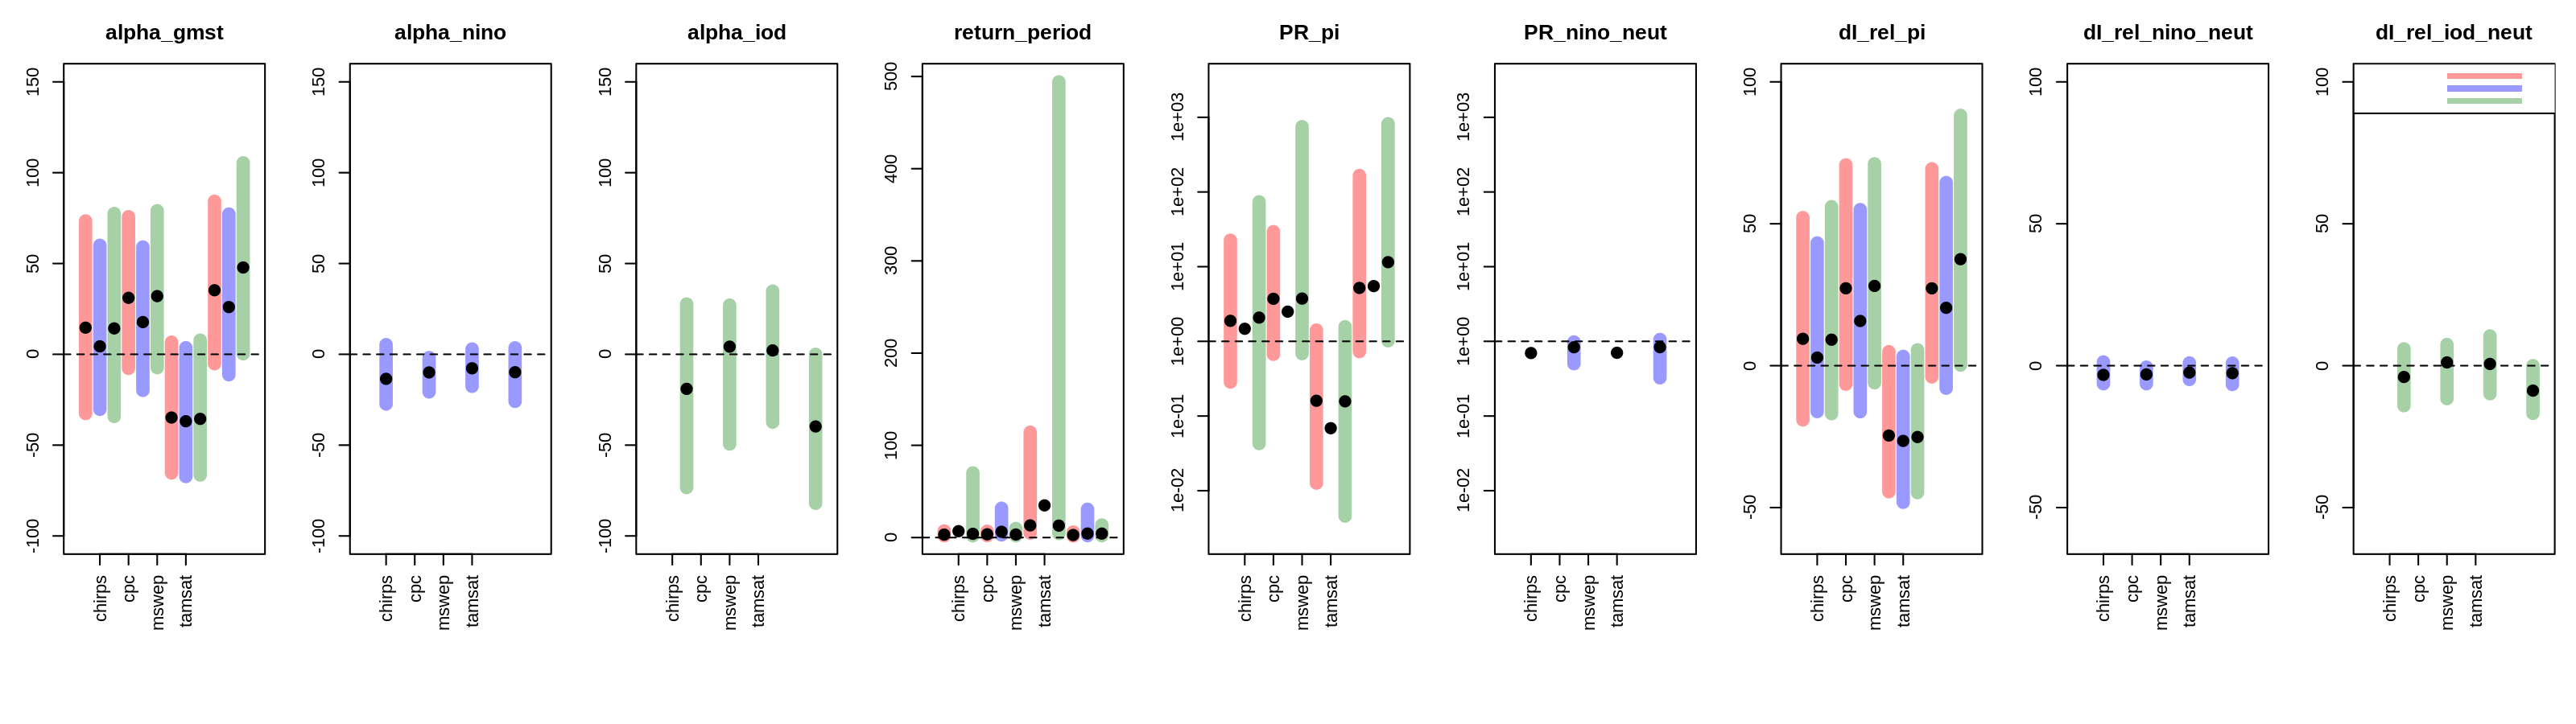

In [163]:
plot_pars <- c("alpha_gmst", "alpha_nino", "alpha_iod", "return_period", "PR_pi", "PR_nino_neut", "dI_rel_pi", "dI_rel_nino_neut", "dI_rel_iod_neut")

ds_colours <- adjustcolor(c("red", "blue", "forestgreen", "purple"), alpha = 0.4)[1:nr]
prep_window(c(1,4), h = 4.5); par(mar = c(8,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- all_res[,,r,]
        res[!is.finite(res)] <- NA
        ylim = range(res, na.rm = T)
        logaxs = ""
        h = 0
        
        nr <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(all_res[,,grepl("alpha", dimnames(all_res)[[3]]),]), na.rm = T)
        } else if(grepl("dI_abs", r)) {
            ylim = range(pretty(all_res[,,grepl("dI_abs", dimnames(all_res)[[3]]),]), na.rm = T)
        } else if(grepl("dI_rel", r)) {
            ylim = range(pretty(all_res[,,grepl("dI_rel", dimnames(all_res)[[3]]),]), na.rm = T)
        } else if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(all_res[,,grepl("PR", dimnames(all_res)[[3]]),])), na.rm = T))
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,nr*nc+1), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = (1:nc)*(nr-1), labels = colnames(res), las = 2)
        segments(x0 = 1:(nr*nc), y0 = res[,,"X2.5."], y1 = res[,,"X97.5."], lwd = 8, col = ds_colours)
        points(1:(nr*nc), res[,,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }
legend("topleft", legend = rownames(all_res), fill = ds_colours, border = NA)

## Fitted trend plots

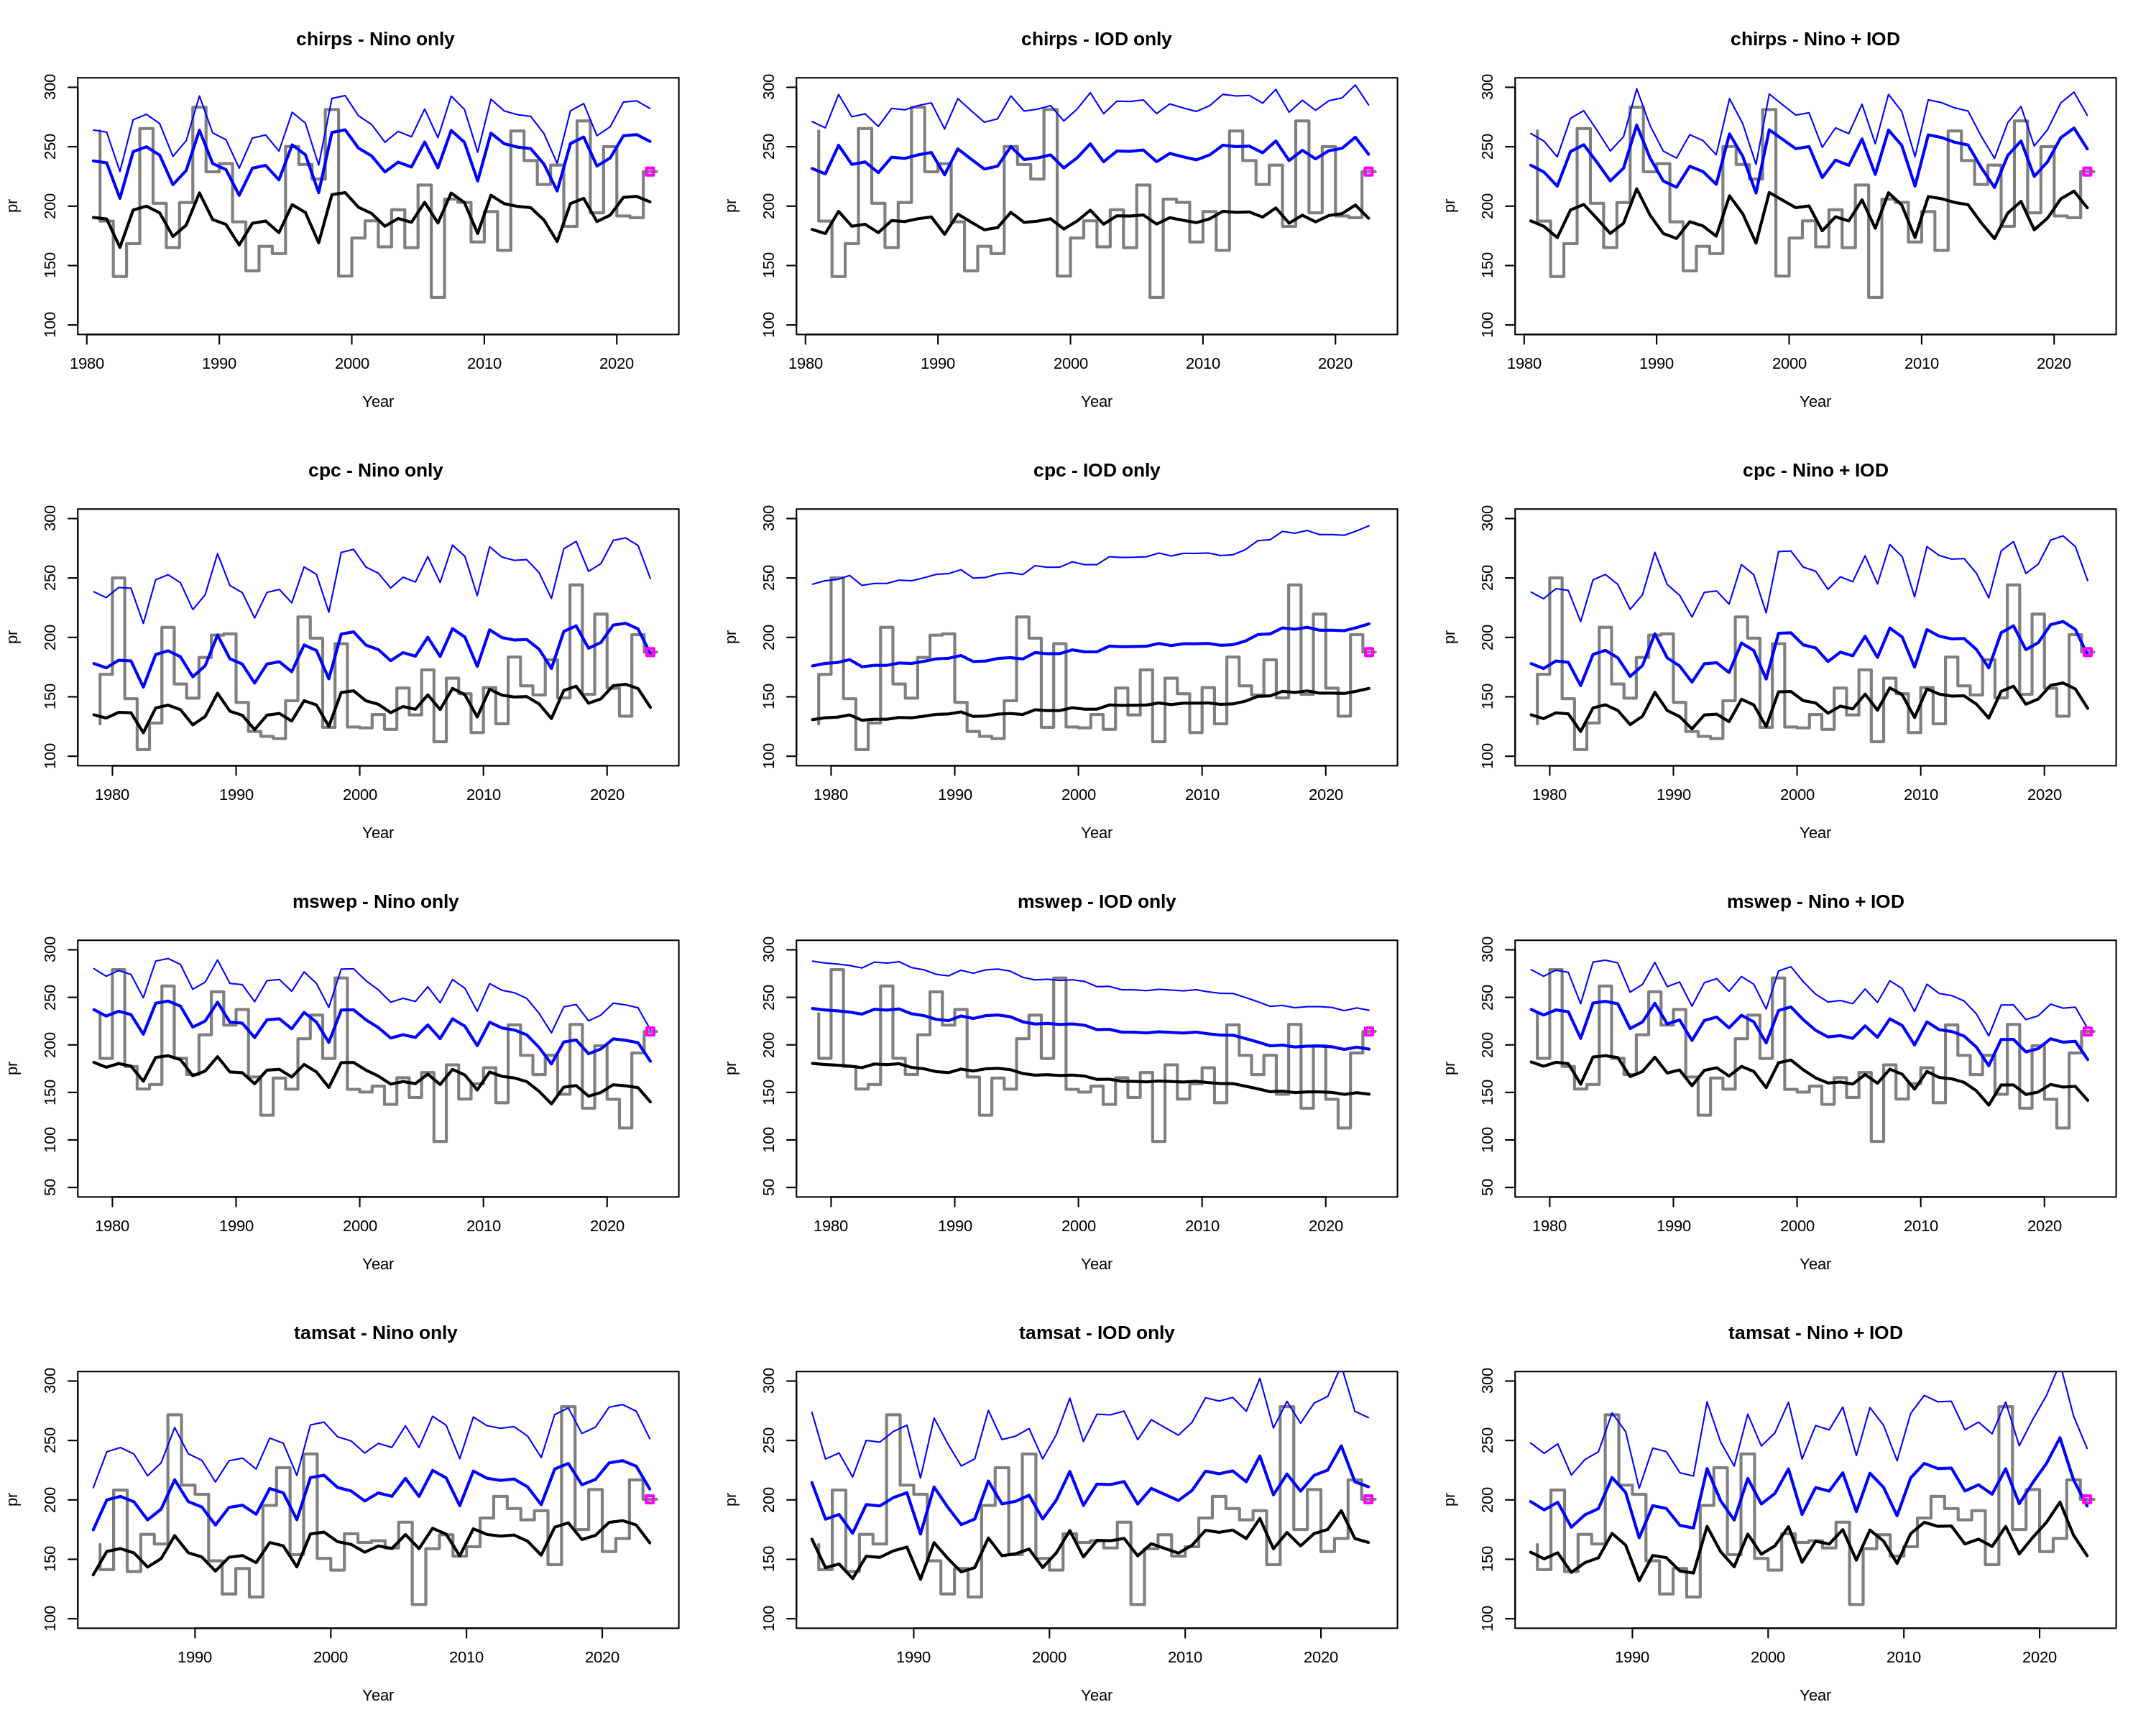

In [76]:
prep_window(c(length(datasets), 3), h = 3, w = 5)
for (ds in datasets) {
    
    df_ds <- merge(df, load_ts(paste0("ts/EA-floods_rx30day_obs_",ds,".dat"), col.names = c("year", "pr")))
    mdl_nino <- fit_ns("gev", "fixeddisp", df_ds, "pr", c("gmst", "nino"), lower = F)
    mdl_iod <- fit_ns("gev", "fixeddisp", df_ds, "pr", c("gmst", "iod"), lower = F)
    mdl_both <- fit_ns("gev", "fixeddisp", df_ds, "pr", c("gmst", "nino", "iod"), lower = F)
    
    plot_trend(mdl_nino, legend_pos = NA, main = paste0(ds, " - Nino only "))
    plot_trend(mdl_iod, legend_pos = NA, main = paste0(ds, " - IOD only"))
    plot_trend(mdl_both, legend_pos = NA, main = paste0(ds, " - Nino + IOD"))
}

## Residuals

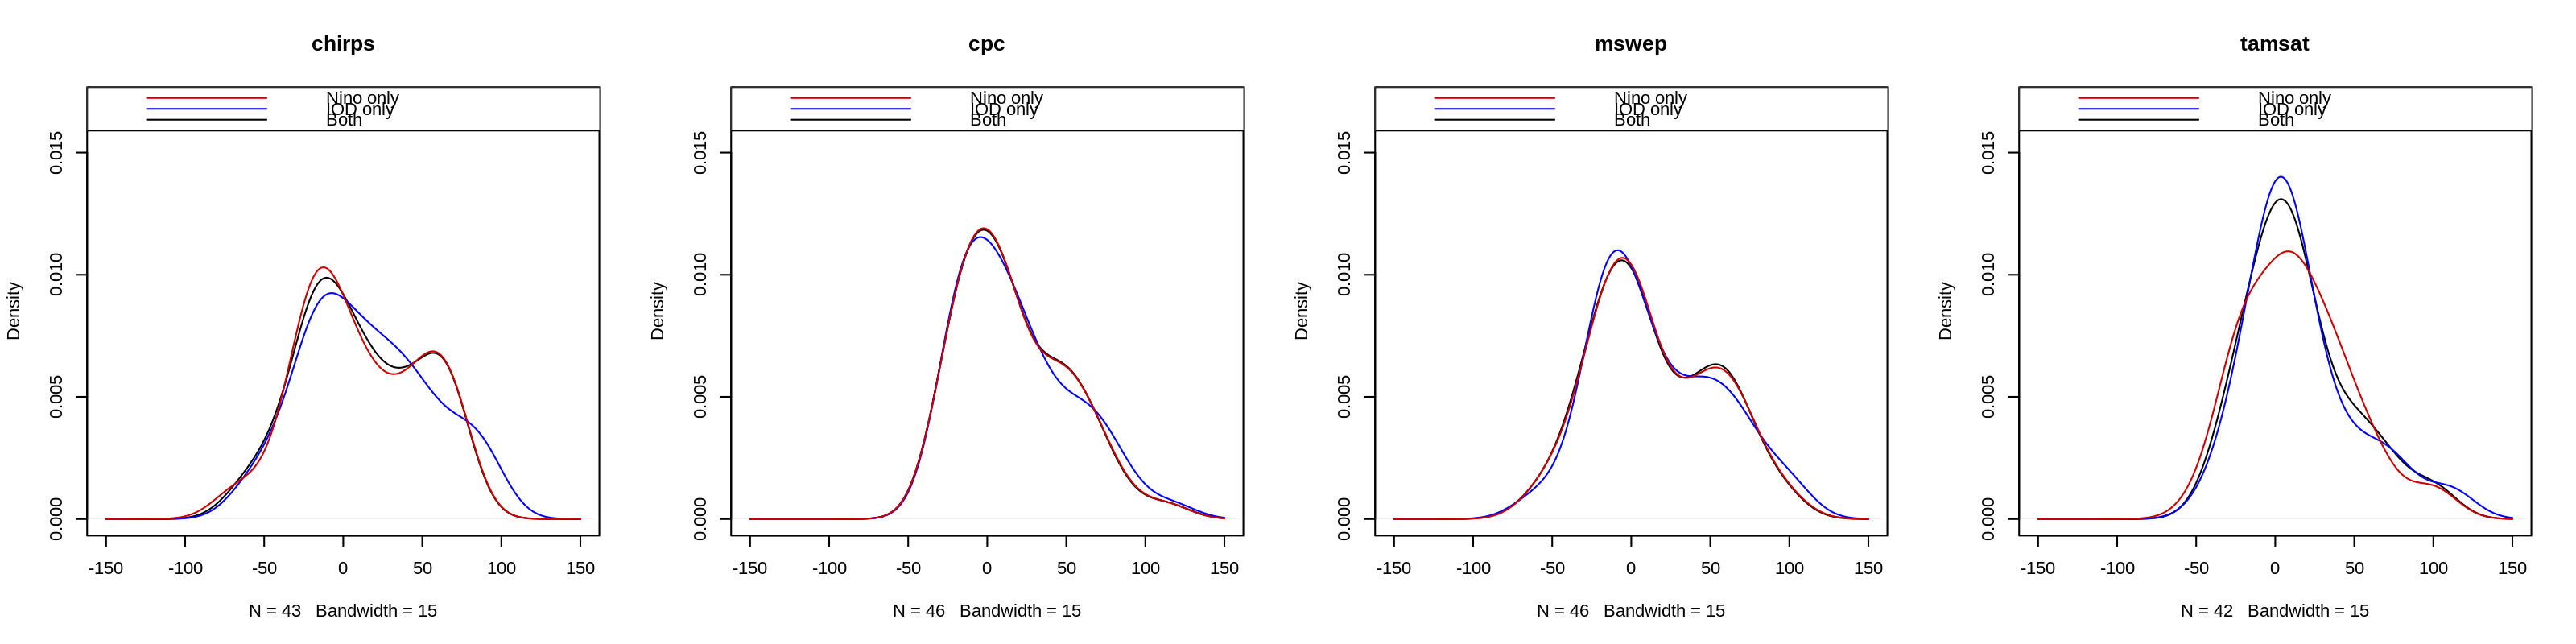

In [122]:
# Distribution of residuals from each model
prep_window(c(1,4))
for (ds in datasets) {
    mdl_n <- models_nino[[ds]]
    mdl_i <- models_iod[[ds]]
    mdl_in <- models_nino_iod[[ds]]
    
    plot(density(mdl_in$x - ns_pars(mdl_in)$loc, from = -150, to = 150, bw = 15), col = "black", main = ds, ylim = c(0,0.017), xlim = c(-150,150))
    lines(density(mdl_i$x - ns_pars(mdl_i)$loc, from = -150, to = 150, bw = 15), col = "blue")
    lines(density(mdl_n$x - ns_pars(mdl_n)$loc, from = -150, to = 150, bw = 15), col = "red3")
    
    legend("topleft", c("Nino only", "IOD only", "Both"), lty = 1, col = c("red3", "blue", "black"))
}

# Fit linear model to gridded data

In [7]:
datasets = c("chirps", "cpc", "mswep", "tamsat")
varnm = "rx30day"

gmst = read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# define factual & counterfactual covariates
cov_2024 <- gmst[gmst$year == 2024,"gmst", drop = F]
cov_cf <- rbind("pi" = cov_2024 - c(1.2,0,0))

In [ ]:
fl = list.files("data/flattened", pattern = varnm, full.names = T)
for(fnm in fl) {
    
    res_fnm <- gsub("flattened", "gridded-res", fnm)
    
    if (!file.exists(res_fnm)) {
        df <- read.csv(fnm, skip = 3, header = F)
        colnames(df)[1] <- "year"
        df <- merge(gmst, df)

        # fit nonstationary model to all grid cells
        models <- sapply(colnames(df)[grepl("V", colnames(df))], function(cnm) {
            df_c <- df[,c("year", "gmst", cnm)]
            tryCatch({
                fit_ns("gev", "fixeddisp", df_c, cnm, c("gmst"), lower = F)
            }, error = function(cond) { return(NULL) })
        }, simplify = F)

        # get all model results & save as .csv to be reconstructed & plotted in python
        fitted_res <- sapply(models, function(mdl) {
            if(!is.null(unlist(mdl)[1])) {
                mdl_ests(mdl, cov_f = cov_2024, cov_cf = cov_cf)
            } else {
                rep(NA, 10)
            }})
        write.csv(fitted_res, res_fnm)
    }
}